# Montando ambiente

In [94]:
import mysql.connector
import nltk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter


stop_words = set(stopwords.words('portuguese'))
nltk.download('punkt')

# Configuração da conexão com o banco
DB_CONFIG = {
    "host": "localhost",
    "user": "root",
    "password": "",
    "database": "graph_db"
}

"""Cria arestas com base em frases de exemplo."""
frases = [
        "Comece a gravação de áudio",
        "Salve esse texto importante",
        "Defina um alerta para amanhã",
        "Quero a gravação dessa reunião",
        "Salve a anotação rapidamente"
]

comandos = [
        "Iniciar gravação",
        "Salvar texto",
        "Configurar alerta",
        "Iniciar gravação",
        "Salvar anotação"
]

matriz_teste = [
    ["Dê início à captura de som", "Iniciar gravação"],
    ["Gostaria de ouvir isso depois", "Iniciar gravação"],
    ["Por gentileza, registre este momento", "Iniciar gravação"],
    ["Ative o modo gravação", "Iniciar gravação"],
    ["Preserve este áudio para mim", "Iniciar gravação"],
    ["Assegure que este texto esteja seguro", "Salvar texto"],
    ["Faça uma cópia deste conteúdo", "Salvar texto"],
    ["Deixe este texto registrado", "Salvar texto"],
    ["Fixe esta informação", "Salvar texto"],
    ["Quero ter este texto para depois", "Salvar texto"],
    ["Estabeleça um aviso para 19h", "Configurar alerta"],
    ["Preciso ser lembrado às 20h", "Configurar alerta"],
    ["Por favor, defina um bip para 21h", "Configurar alerta"],
    ["Quero um aviso sonoro para as 22h", "Configurar alerta"],
    ["Faça um lembrete vibrar às 23h", "Configurar alerta"],
    ["Gostaria de ter isso em minhas notas", "Salvar anotação"],
    ["Anote isto para mim", "Salvar anotação"],
    ["Mantenha esta informação como uma nota", "Salvar anotação"],
    ["Quero isto em formato de anotação", "Salvar anotação"],
    ["Por favor, transforme isso em uma nota", "Salvar anotação"]
]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marcelo.maurin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marcelo.maurin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Declara a funçao de conexao

In [64]:
def connect_to_database():
    """Retorna uma conexão com o banco de dados."""
    return mysql.connector.connect(**DB_CONFIG)

## Função Pega texto

In [65]:
def get_id(name, table):
    """Busca o ID de um item pelo nome, na tabela especificada."""
    connection = connect_to_database()
    cursor = connection.cursor()
    
    column = "word_name" if table == "words" else "command_name"
    query = f"SELECT * FROM {table} WHERE {column}=%s"
    cursor.execute(query, (name,))
    result = cursor.fetchone()
    
    cursor.close()
    connection.close()
    
    return result[0] if result else None

## Popula Arestas

In [66]:
def populaArestas(word1, word2, command):
    """Popula a tabela edges com as relações entre palavras e comando."""
    connection = connect_to_database()
    cursor = connection.cursor()
    
    word1_id = get_id(word1, 'words')
    word2_id = get_id(word2, 'words')
    command_id = get_id(command, 'commands')
    
    if not word1_id or not word2_id or not command_id:
        print(f"Erro: Palavras ou comando não encontrados: '{word1}', '{word2}', '{command}'")
        return
    
    insert_query = "INSERT INTO edges (word_id, command_id) VALUES (%s, %s)"
    
    # Inserindo relação da primeira palavra com o comando
    cursor.execute(insert_query, (word1_id, command_id))
    
    # Inserindo relação da segunda palavra com o comando
    cursor.execute(insert_query, (word2_id, command_id))
    
    connection.commit()
    cursor.close()
    connection.close()

## Cadastra Comandos

In [67]:
def cadastreCMD(command_name):
    """Cadastra um novo comando na tabela commands."""
    connection = connect_to_database()
    cursor = connection.cursor()
    
    insert_query = "INSERT INTO commands (command_name) VALUES (%s)"
    
    try:
        cursor.execute(insert_query, (command_name,))
        connection.commit()
    except mysql.connector.Error as err:
        print(f"Erro ao inserir comando '{command_name}': {err}")
    
    cursor.close()
    connection.close()

def ExemploCMD():   
    for cmd in comandos:
        cadastreCMD(cmd)

## Cadastra Palavras

In [74]:
# Função para cadastrar palavras
def CadastraWords(word_name):
    connection = connect_to_database()
    cursor = connection.cursor()
    
    # Verifica se a palavra já está cadastrada
    cursor.execute("SELECT word_id FROM words WHERE word_name = %s", (word_name,))
    result = cursor.fetchone()
    if result:
        return result[0]
    
    cursor.execute("INSERT INTO words (word_name) VALUES (%s)", (word_name,))
    connection.commit()
    word_id = cursor.lastrowid
    
    cursor.close()
    connection.close()
    
    return word_id


def ExemploWords():
  for frase in frases:
        palavras = frase.split() # Separa a frase em palavras individuais
        for palavra in palavras:
            # Ignoramos palavras muito comuns (stop words) e números
            if palavra.lower() not in stop_words and not palavra.isnumeric():
                CadastraWords(palavra)


## Cria Arestas

In [75]:
def get_id_words(value, column_name):
    """Retorna o ID associado a um valor em uma coluna e tabela específicos."""
    connection = connect_to_database()
    cursor = connection.cursor()

    select_query = f"SELECT word_id FROM words WHERE {column_name} = %s"
    cursor.execute(select_query, (value,))

    result = cursor.fetchone()
    cursor.close()
    connection.close()

    return result[0] if result else None

def get_id_commands(value, column_name):
    """Retorna o ID associado a um valor em uma coluna e tabela específicos."""
    connection = connect_to_database()
    cursor = connection.cursor()

    select_query = f"SELECT command_id FROM commands WHERE {column_name} = %s"
    cursor.execute(select_query, (value,))

    result = cursor.fetchone()
    cursor.close()
    connection.close()

    return result[0] if result else None


def CriaArestas(Word1, Word2, Cmd):
    print(Word1)
    print(Word2)
    """Cria uma aresta associando Word1 e Word2 ao comando Cmd."""
    #word1_id = get_id_words(Word1, "word_name")
    #word2_id = get_id_words(Word2, "word_name")
    word1_id = CadastraWords(Word1)
    word2_id = CadastraWords(Word2)
    cmd_id = get_id_commands(Cmd,  "command_name")

    print(word1_id);
    print(word2_id);
    print(cmd_id);

    if not word1_id or not word2_id or not cmd_id:
        print("Erro: Um ou mais valores não foram encontrados no banco de dados.")
        return

    connection = connect_to_database()
    cursor = connection.cursor()
    
    insert_query = """
    INSERT INTO edges (word_id1, word_id2, command_id)
    VALUES (%s, %s, %s)
    """
    
    try:
        cursor.execute(insert_query, (word1_id, word2_id, cmd_id))
        connection.commit()
    except mysql.connector.Error as err:
        print(f"Erro ao inserir aresta: {err}")
    
    cursor.close()
    connection.close()

## Exemplo Arestas

In [76]:
def ExemploAresta():
    for index, frase in enumerate(frases):
        palavras = [palavra for palavra in frase.split() if palavra.lower() not in stop_words and not palavra.isnumeric()]
        
        for i in range(len(palavras) - 1):
            # Criamos arestas entre palavras sequenciais e associamos a um comando
            CriaArestas(palavras[i], palavras[i+1], comandos[index])


# Juntando Tudo

In [77]:
connect_to_database()

#ExemploWords();

#ExemploCMD();

#ExemploAresta();

In [78]:
# Função para popular com dados de teste
def Popula_Teste():
    stop_words = set(stopwords.words('portuguese'))

    for item in matriz_teste:
        frase, comando = item
        words = word_tokenize(frase, language="portuguese")
        filtered_words = [w for w in words if w.lower() not in stop_words and w.isalpha()]

        for i in range(len(filtered_words) - 1):
            CriaArestas(filtered_words[i], filtered_words[i + 1], comando)


In [79]:
Popula_Teste()

Dê
início
58
59
5
início
captura
59
60
5
captura
som
60
61
5
Gostaria
ouvir
62
63
5
gentileza
registre
64
65
5
registre
momento
65
66
5
Ative
modo
67
68
5
modo
gravação
68
45
5
Preserve
áudio
69
46
5
áudio
mim
46
70
5
Assegure
texto
71
48
6
texto
seguro
48
72
6
Faça
cópia
73
74
6
cópia
deste
74
75
6
deste
conteúdo
75
76
6
Deixe
texto
77
48
6
texto
registrado
48
78
6
Fixe
informação
79
80
6
Quero
ter
53
81
6
ter
texto
81
48
6
Estabeleça
aviso
82
83
7
Preciso
lembrado
84
85
7
favor
defina
86
50
7
defina
bip
50
87
7
Quero
aviso
53
83
7
aviso
sonoro
83
88
7
Faça
lembrete
73
89
7
lembrete
vibrar
89
90
7
Gostaria
ter
62
81
8
ter
notas
81
91
8
Anote
mim
92
70
8
Mantenha
informação
93
80
8
informação
nota
80
94
8
Quero
formato
53
95
8
formato
anotação
95
56
8
favor
transforme
86
96
8
transforme
nota
96
94
8


## Validação dos dados de teste

In [83]:
def Teste_Validacao(Frase, comando):
    stop_words = set(stopwords.words('portuguese'))
    connection = connect_to_database()
    cursor = connection.cursor()
    
    # Tokenize e limpe a frase
    words = word_tokenize(Frase, language="portuguese")
    filtered_words = [w.lower() for w in words if w.lower() not in stop_words and w.isalpha()]

    # Obtenha o ID do comando
    cursor.execute("SELECT command_id FROM commands WHERE command_name = %s", (comando,))
    command_id = cursor.fetchone()
    if not command_id:
        return "Comando não encontrado."
    command_id = command_id[0]

    # Verifique a presença de pares de palavras na tabela edges
    total_matches = 0
    for i in range(len(filtered_words) - 1):
        cursor.execute("""SELECT COUNT(*) FROM edges
                          WHERE word_id1 = (SELECT word_id FROM words WHERE word_name = %s)
                          AND word_id2 = (SELECT word_id FROM words WHERE word_name = %s)
                          AND command_id = %s""", (filtered_words[i], filtered_words[i + 1], command_id))
        total_matches += cursor.fetchone()[0]

    # Matriz de confusão: [Predicted True, Predicted False; Actual True, Actual False]
    confusion_matrix = [[0, 0], [0, 0]]
    if total_matches > 0:  # Se houver combinações, assuma que a previsão é verdadeira
        confusion_matrix[0][0] = 1
    else:  # Se não houver combinações, assuma que a previsão é falsa
        confusion_matrix[1][1] = 1

    cursor.close()
    connection.close()

    return confusion_matrix

In [107]:
def plot_confusion_matrix(confusion_matrix, classes, title='Matriz de Confusão', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_matrix, annot=True, cmap=cmap, fmt='g', xticklabels=classes, yticklabels=classes)
    plt.ylabel('Comando verdadeiro')
    plt.xlabel('Comando previsto')
    plt.title(title)
    plt.show()

def Testa_Validacao():
    
    conn = connect_to_database()
    cursor = conn.cursor()
    
    # Lista de stopwords em português
    stop_words = set(stopwords.words('portuguese'))
    
    confusion_matrix = np.zeros((len(comandos), len(comandos)))

    for item in matriz_teste:
        frase, comando_verdadeiro = item
        
        # Processa a frase: remove stopwords, converte para minúsculo
        palavras = [word for word in frase.lower().split() if word not in stop_words and not word.isdigit()]

        # Encontre os IDs das palavras
        word_ids = []
        for palavra in palavras:
            cursor.execute("SELECT word_id FROM words WHERE word_name = %s", (palavra,))
            result = cursor.fetchone()
            if result:
                word_ids.append(result[0])

        # Encontre a aresta com maior frequência baseada nas palavras
        comando_previsto = None
        max_count = -1
        for i in range(len(word_ids)-1):
            cursor.execute("""
                SELECT command_id, COUNT(*) as freq
                FROM edges
                WHERE word_id1 = %s AND word_id2 = %s
                GROUP BY command_id
                ORDER BY freq DESC
                LIMIT 1
            """, (word_ids[i], word_ids[i+1]))
            result = cursor.fetchone()
            if result and result[1] > max_count:
                comando_previsto = result[0]
                max_count = result[1]
        
        if comando_previsto:
            # Converte o ID do comando para nome
            cursor.execute("SELECT command_name FROM commands WHERE command_id = %s", (comando_previsto,))
            result = cursor.fetchone()
            if result:
                comando_previsto_name = result[0]
                confusion_matrix[comandos.index(comando_verdadeiro)][comandos.index(comando_previsto_name)] += 1

    conn.close()

    # Plota a matriz de confusão
    plt.figure(figsize=(10,7))
    sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", xticklabels=comandos, yticklabels=comandos)
    plt.xlabel('Comando Previsto')
    plt.ylabel('Comando Verdadeiro')
    plt.show()


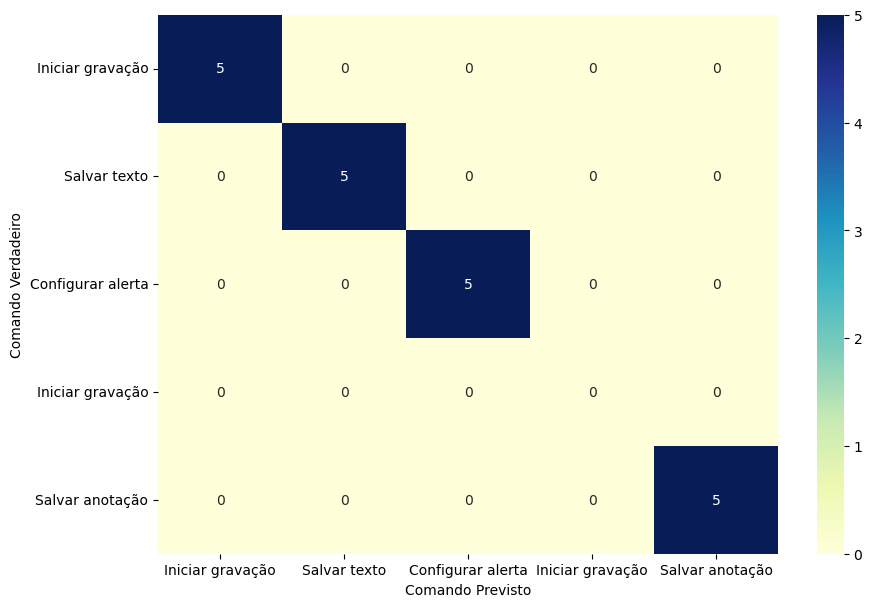

In [108]:
Testa_Validacao()